# IMDB Movie Review 
In this project i use IMDb movie review dataset to build a sentiment analysis model that can classify text as positive, negative or neutral 

## Loading data

In [2]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")
print(df.head())
print(df.shape)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)


## Data Exploration
Here i am checking to see if there is an inbalance so that we can apply corrective measures

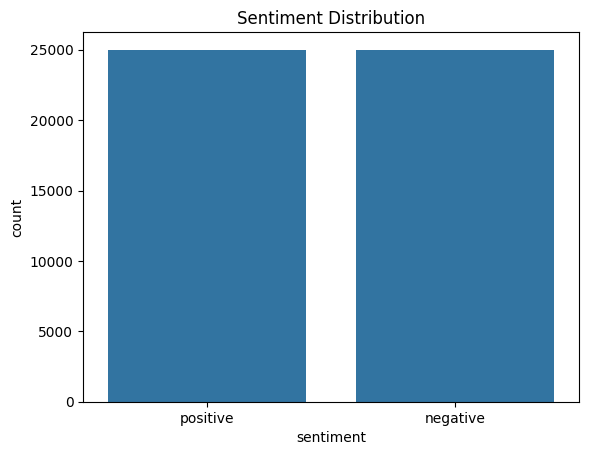

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

There is a balance between  positive and negative reviews so i am not going to worry about applying techniques to correct the data

## Data Preprocessing
Here i will do a couple of operations:
- lowercase
- tokenization
- stopword removal
- punctuation removal

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ianmadhara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ianmadhara/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


## Text Vectorization using TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['clean_review']).toarray()
y = df['sentiment'].map({'positive': 1, 'negative': 0})
print(X.shape)

(50000, 5000)


## Train-Validation-Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (35000, 5000)
Validation set size: (7500, 5000)
Test set size: (7500, 5000)


## Train Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Model Evaluation

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3750
           1       0.88      0.89      0.88      3750

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



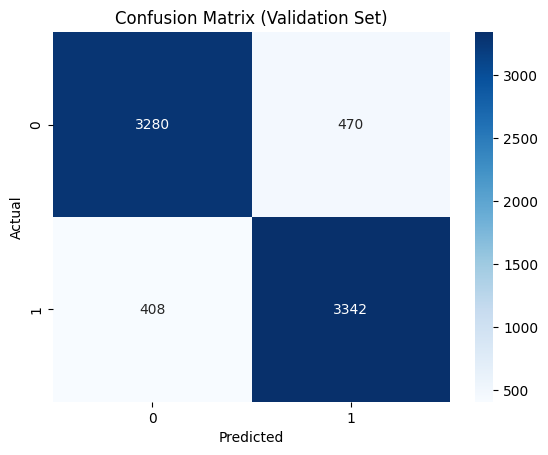

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val)
print("Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

## Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("Best parameters found:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Retrain with the best parameters
best_model = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'C': 1, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8810285638871781


LogisticRegression(C=1, max_iter=1000, solver='liblinear')

## Final Evaluation on Test Set

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3750
           1       0.88      0.90      0.89      3750

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



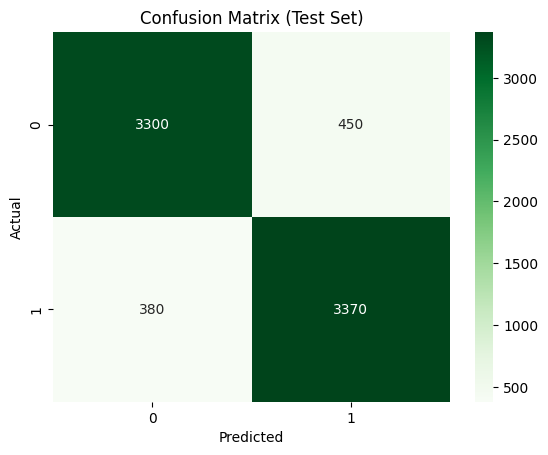

In [19]:
y_test_pred = best_model.predict(X_test)
print("Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## Save Your Model & TF-IDF Vectorizer

In [20]:
import joblib

joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']